# MIE1624 Course Project
By: Alexis Bruneau, Yi Zhang, Houze Xu, Yann, \
Submitted to: Prof. Oleksandr Romanko 

In [ ]:
# Modify code if not run on Jupyter Notebook
!pip install langdetect
!pip3 install flair
!pip install git+https://github.com/LIAAD/yake

In [ ]:
# Handling Table
import numpy as np
import pandas as pd

#Machine Learning Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import XGBClassifier
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from tensorflow import keras
import tensorflow as tf

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from collections import Counter
import nltk.corpus
import requests
import re


# Visualisation
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

#Other
from google.colab import files
import time

In [3]:
from langdetect import detect
import flair
import yake

In [4]:
#Upload the folloinwg files (Dataset used in Part 1-2-3)
# Sentiment_analysis.csv (Dataset 1 Part 1)
# tw_reply.csv (Dataset 1 Part 2)
# tw.csv (Summary of Dataset 1 Part 2)
# 30K Tweets with russiaukrainewar hashtag.csv (Dataset 2 Part 2)

# Skip this line if not on google golab, but make sure that datasets are in some folder directory as code)

uploaded = files.upload()

Saving 30K Tweets with russiaukrainewar hashtag.csv to 30K Tweets with russiaukrainewar hashtag.csv
Saving sentiment_analysis.csv to sentiment_analysis.csv
Saving tw.csv to tw.csv
Saving tw_reply.csv to tw_reply.csv


#Part 1 Sentiment Modeling

In this section we will analyze the sentiment_analysis.csv file. We will do some data processing, apply TF_IDF, and then use the following algorithms to predict the sentiment of each tweets:
- Logistic Regression
- Naives Bayes
- SVM
- Decision Tree
- XGBoost

After testing each model, we will use the model with the best result.

In [ ]:
df_sentiment = pd.read_csv('sentiment_analysis.csv')
df_sentiment.head()

## Data preprocessing (words)

In [6]:
def text_processing(df, feature_name):
  '''
  The purpose of this function is to clean out the text removing unwanted characters. 
  Input:
  --------------
  datatable with column to clean --> dataframe
  feature_name --> string

  Output Cleaned datatable

  '''
  nltk.download('stopwords')
  df2 = df.copy()

  # Clean text data by removing any links 
  df2[feature_name] = df2[feature_name].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

  # Put all words to lower case 
  df2[feature_name] = df2[feature_name].str.lower()

  #Removing stop words (supposed to only keep english words/ doesn't work too well)
  stop = stopwords.words('english')
  df2[feature_name] = df2[feature_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  #Remove unicode characters
  df2[feature_name]=df2[feature_name].str.encode('ascii', 'ignore').str.decode('ascii')

  # Removes rt @
  df2[feature_name] = df2[feature_name].str.replace('rt @[^\s]*',"")

  # Remove @username left
  df2[feature_name] = df2[feature_name].str.replace('@[^\s]*',"")

  #Removes any punctuation
  df2[feature_name] = df2[feature_name].str.replace(r'[^\w\s]+', '')

  # Remove numbers
  df2[feature_name] = df2[feature_name].str.replace('\d+', '')


  return df2 
  

The following code calls the function to clean the Dataset 1 Part 1 and save the results as a csv.



In [ ]:
df_sentiment_clean = text_processing(df_sentiment,'text')

In [8]:
# use this line to remove any text that was not cleanned properly by removing anything with more than one space
df_sentiment_clean['text'] = df_sentiment_clean['text'].replace(r'\s+', ' ', regex=True)

The function is used to split the data into a training and testing set.

In [9]:
def split_data(X,y):
  '''
  X -> Datatable with features
  y -> Datatable only containing target
  Split data into split and train
  '''
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
  
  return X_train, X_test, y_train, y_test

In [10]:
# Calling function to split data into train and testing set
X = df_sentiment_clean['text']
y = df_sentiment_clean['label']
X_train, X_test, y_train, y_test = split_data(X,y)

## Classification Algorithms

In this section we will implement different classification algorithms. It is to note that some algortihms took a really long time. For the interest of time, we only kept models that were able to run cross validation in less than 30-40 minutes. We also saved the results as text files underneath each block of code.

In [11]:
# Use TfidfVectorizer on text
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit_transform(X_train)
X_train_tf = vectorizer.transform(X_train)
X_test_tf = vectorizer.transform(X_test)



### Logistic Regression

In [12]:
# Use grid search for Logistic Regression with a cross validation of 5

param_grid_LR = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

LR = LogisticRegression(max_iter=750)
clf_LR = GridSearchCV(LR, param_grid=param_grid_LR, scoring='accuracy',cv=5)
clf_LR.fit(X_train_tf, y_train)
y_pred = clf_LR.predict(X_test_tf)
LR_score = balanced_accuracy_score(y_test, y_pred)

print(f"The best hyperparameters are: {clf_LR.best_params_}")
print(f"The accuracy is {LR_score}")

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver n

The best hyperparameters are: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
The accuracy is 0.9569633780840416


Logistic Regression Results:

One or more of the test scores are non-finite: [       nan        nan 0.94604508 0.95331038 0.95329902 0.95330356
        nan        nan 0.96012827 0.95943104 0.95943785 0.95943558
        nan        nan 0.95966723 0.95996248 0.9599534  0.95996929]
  category=UserWarning,
The best hyperparameters are: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
The accuracy is 0.9569633780840416



#### Logistic Regression Results
The best hyperparameters are: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
The accuracy is 0.9569701122721679

### Naive Bayes

Naives Bayes works well for large dataset. Also, it is to note that we did not find a good way to do gridsearch for Naive Bayes.

In [13]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train_tf,y_train)
y_pred = clf_nb.predict(X_test_tf)
score = balanced_accuracy_score(y_test, y_pred)
print(f"The accuracy is {score}")

The accuracy is 0.897377467140327


The accuracy for Naive Bayes is The accuracy is 0.897377467140327

### SVM

We tried SVM, but it was super slow. Not the best model for large dataset. For this reason we lowered the number of hyperparameter used in the gridsearch.

In [14]:
param_grid = {'C': [0.001, 0.1, 1, 10]} 
svm_model = LinearSVC(random_state=0)
svm_grid = GridSearchCV(svm_model, param_grid, cv=5)
  
# fitting the model for grid search
svm_grid.fit(X_train_tf, y_train)
y_pred = svm_grid.predict(X_test_tf)
score = accuracy_score(y_pred, y_test)

print(f"The best hyperparameters are: {svm_grid.best_params_}")
print(f"The score is {score}")


The best hyperparameters are: {'C': 1}
The score is 0.9597925126500059


The results for SVM
The best hyperparameters are: {'C': 1}
The score is 0.9597925126500059

### Decision Tree

In [15]:
params = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 50, 100],
    'criterion': ["gini", "entropy"]
}
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search.fit(X_train_tf, y_train)
y_pred = grid_search.predict(X_test_tf)
score = accuracy_score(y_pred, y_test)
print(f"The best hyperparameters are: {grid_search.best_params_}")
print(f"The score is {score}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
The best hyperparameters are: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}
The score is 0.8027416673479956


### XGBoost

In [16]:

params = {'max_depth': [3, 6, 10],
          'learning_rate': [0.01, 0.1, 0.5],}
estimator = XGBClassifier(seed=42)

# clf_xgb = GridSearchCV(estimator=estimator,
#                        param_grid=params,
#                        scoring='accuracy',n_jobs=4,verbose=1,cv=5)
grid_search_xgb = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5,
    verbose=1)
grid_search_xgb.fit(X_train_tf, y_train)
y_pred = grid_search_xgb.predict(X_test_tf)
score = accuracy_score(y_pred, y_test)
print(f"The best hyperparameters are: {grid_search_xgb.best_params_}")
print(f"The score is {score}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best hyperparameters are: {'learning_rate': 0.5, 'max_depth': 10}
The score is 0.9444217334823173


Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best hyperparameters are: {'learning_rate': 0.5, 'max_depth': 10}
The score is 0.9444217334823173

After testing 5 different algorithms, Logistic Regression was the best model when using accuracy as a benchmark. It is to note that it got the same results as SVM. However, the SVM model performed much slower than the Logistic Regression. Hence, we decided to continue the analysis with Logistic Regression. The following results in order from highest to lower accuracy:

- Logistic Regression accuracy =  0.96
- SVM accuracy 0.96
- XGBoost accuracy = 0.94
- Naive Bayes accuracy = 0.90
- Decision Tree accuracy 0.80

In [17]:
# Print table to csv to use later on
df_sentiment_clean.to_csv('Part1_dataset.csv')
files.download('Part1_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Part 2 - Sentiment Classification

In this section, we used our best model from part 1 and tried to predict the sentiment of tweets from two dataset. Afterwards, we compared our results to alredy pretrained NLP models. The two dataset we used were:
- tw.csv (Dataset 1 Part 2)
- 30K Tweets with russiaukrainewar hashtag.csv (Dataset 2 Part 2)

### Best Model Setup

We will import the table used from question 1 and fit the model using the best algorithm and its best parameter.

In [18]:
# Upload the following documents if not already on google colab
# Upload Part1_dataset from Part 1. If you don't want to run part 1, the csv was provided in the submission
uploaded = files.upload()

Saving Part1_dataset.csv to Part1_dataset (1).csv


In [19]:
df = pd.read_csv('Part1_dataset.csv')
df.head()

Unnamed: 0            ID  \
0           0  7.680980e+17   
1           1  7.680980e+17   
2           2  7.680980e+17   
3           3  7.680980e+17   
4           4  7.680980e+17   

                                                text  label  
0  josh jenkins looking forward tab breeders crow...      1  
1   congratulations pakistan becoming notestteam ...      1  
2   september taking maine mendozas surprise than...      1  
3   newly painted walls thanks million custodial ...      1  
4   excited announce july feschotte lab relocatin...      1

In [20]:
tfidf_vector = TfidfVectorizer(stop_words = 'english')
x = tfidf_vector.fit_transform(df['text'].values.astype('U'))
y = df['label']

**Best model from part 1 is Logistic Regression with parameters {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}**

In [21]:
best_model = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear')
best_model.fit(x, y)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

## Prediction of Elon Musk Tweets

In this section, we try to predict the sentiment of each tweet from the Elon Musk dataset. We will upload the dataset we got from Part 1. 

### Data Cleaning

In [22]:
# The table tw countains the original 5 tweets that have been retweeted
df_tw = pd.read_csv('tw.csv')
df_tw.head()

id                created_at  \
0  1576994262226702336  2022-10-03T17:55:05.000Z   
1  1576973049277992974  2022-10-03T16:30:48.000Z   
2  1576970924968247297  2022-10-03T16:22:21.000Z   
3  1576969255031296000  2022-10-03T16:15:43.000Z   
4  1577853138157158402  2022-10-06T02:47:57.000Z   

                                                text  retweet_count  \
0  Let’s try this then: the will of the people wh...          17804   
1  Also worth noting that a possible, albeit unli...           4706   
2  This is highly likely to be the outcome in the...           4775   
3  Ukraine-Russia Peace:\n\n- Redo elections of a...          20866   
4  @bdquinn @LindseyGrahamSC Kherson and Zaporizh...            341   

   reply_count  like_count  
0        92570       96882  
1        11395       73415  
2        10016       85169  
3       118148       98100  
4         2236        5064

In [23]:
df_tw_reply = pd.read_csv('tw_reply.csv', low_memory = False) # Only use this part of dataset
df_tw_reply.head()

created_at  \
0  2022-10-06T23:58:47.000Z   
1  2022-10-06T23:57:17.000Z   
2  2022-10-06T23:57:11.000Z   
3  2022-10-06T23:56:25.000Z   
4  2022-10-06T23:53:49.000Z   

                                                text  in_reply_to_tweet_id  \
0  @elonmusk This is truly foolish, Elon. Your ow...   1576994262226702336   
1                            @elonmusk Stop the war!   1576994262226702336   
2  @elonmusk After Einstein became famous, report...   1576994262226702336   
3  @elonmusk That’s Ukrainian business. Not yours...   1576994262226702336   
4  @elonmusk your position is phenomenal\n\nthe o...   1576994262226702336   

   retweet_count  reply_count  like_count  
0              0            0           0  
1              0            0           0  
2              1            3          13  
3              0            0           0  
4              1            0           0

In [24]:
print(len(df_tw_reply))
df_tw_reply = df_tw_reply.drop_duplicates(subset=['text'])
print(len(df_tw_reply))

336905
323039


In [25]:
# Create a column Cleaned in which we will process the data
df_tw_reply['Cleaned'] = df_tw_reply['text']
df_tw['Cleaned'] = df_tw['text']

<ipython-input-25-4014534dde4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tw_reply['Cleaned'] = df_tw_reply['text']


In the text processing, we call the function that we created in question 1 to clean the tweets.

In [26]:
df_tw_reply = text_processing(df_tw_reply,'Cleaned')
df_tw_reply.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-6-8a61fa7941ac>:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df2[feature_name] = df2[feature_name].str.replace('rt @[^\s]*',"")
<ipython-input-6-8a61fa7941ac>:32: FutureWarning: The default value of regex will change from True to False in a future version.
  df2[feature_name] = df2[feature_name].str.replace('@[^\s]*',"")
<ipython-input-6-8a61fa7941ac>:35: FutureWarning: The default value of regex will change from True to False in a future version.
  df2[feature_name] = df2[feature_name].str.replace(r'[^\w\s]+', '')
<ipython-input-6-8a61fa7941ac>:38: FutureWarning: The default value of regex will change from True to False in a future version.
  df2[feature_name] = df2[feature_name].str.replace('\d+', '')


created_at  \
0  2022-10-06T23:58:47.000Z   
1  2022-10-06T23:57:17.000Z   
2  2022-10-06T23:57:11.000Z   
3  2022-10-06T23:56:25.000Z   
4  2022-10-06T23:53:49.000Z   

                                                text  in_reply_to_tweet_id  \
0  @elonmusk This is truly foolish, Elon. Your ow...   1576994262226702336   
1                            @elonmusk Stop the war!   1576994262226702336   
2  @elonmusk After Einstein became famous, report...   1576994262226702336   
3  @elonmusk That’s Ukrainian business. Not yours...   1576994262226702336   
4  @elonmusk your position is phenomenal\n\nthe o...   1576994262226702336   

   retweet_count  reply_count  like_count  \
0              0            0           0   
1              0            0           0   
2              1            3          13   
3              0            0           0   
4              1            0           0   

                                             Cleaned  
0   truly foolish elon life experience taught bet...  
1                                           stop war  
2   einstein became famous reporters started inte...  
3   thats ukrainian business russia disagree impe...  
4   position phenomenal opinion western world iss...

In [27]:
# Use tfidf on Cleaned values
x_tw_reply = tfidf_vector.transform(df_tw_reply['Cleaned'].values.astype('U'))

### Predictions

We make the predictions of whether it is a positive sentiment 1 or negative 0 using the model from part 1.

In [28]:
x_tw_reply_pred = best_model.predict(x_tw_reply)
df_tw_reply['label_predict'] = x_tw_reply_pred
df_tw_reply.head()
df_tw_reply.to_csv('Prediction - tw_reply.csv') 
files.download('Prediction - tw_reply.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### View Results

In this section we will print the results of some of our predictions for the positive and negative sentiment

In [29]:
# Only show table with cleaned and label predict
df_results = df_tw_reply[['text','Cleaned','label_predict']].copy()

In [30]:
# loop through 15 first tweets with negative feelings
Negative_feeling = df_results[df_results['label_predict'] == 0]

print("Negative Sentiment")
for i in range(len(Negative_feeling)):
  print(i)
  print(f"Original Text: {Negative_feeling['text'].iloc[i]}")
  print(f"Cleaned Text : {Negative_feeling['Cleaned'].iloc[i]}\n")
  if i == 15:
    break

Negative Sentiment
0
Original Text: @elonmusk Stop the war!
Cleaned Text :  stop war

1
Original Text: @elonmusk After Einstein became famous, reporters started interviewing him on topics ranging from quantum mechanics to politics, daily events, and everything in between.

Einstein had the humbleness to politely decline answering questions on topics unrelated to his areas of expertise.
Cleaned Text :  einstein became famous reporters started interviewing topics ranging quantum mechanics politics daily events everything between einstein humbleness politely decline answering questions topics unrelated areas expertise

2
Original Text: @elonmusk That’s Ukrainian business. Not yours or Russia. If you disagree you are an imperialist. Just like Catalonia is Spain’s business.
Cleaned Text :  thats ukrainian business russia disagree imperialist like catalonia spains business

3
Original Text: @elonmusk your position is phenomenal

the opinion of the Western world on any issue is based on fear


In [31]:
# loop through 15 first tweets with positive feelings
Positive_feeling = df_results[df_results['label_predict'] == 1]

print("Negative Sentime")
for i in range(len(Positive_feeling)):
  print(i)
  print(f"Original Text: {Positive_feeling['text'].iloc[i]}")
  print(f"Cleaned Text : {Positive_feeling['Cleaned'].iloc[i]}\n")

  if i == 15:
    break

Negative Sentime
0
Original Text: @elonmusk This is truly foolish, Elon. Your own life experience should have taught you better.
If you choose to live in a country other than your own, then become a part of it. Don’t try to change it to your country of origin.
Cleaned Text :  truly foolish elon life experience taught better choose live country own become part it dont try change country origin

1
Original Text: @elonmusk i think that is a good idea Musk has.Its funny that the Ukrain preident takes it as Musk being pro Russia.ukrain pres is just as against people speaking as putin i guess.
Cleaned Text :  think good idea musk hasits funny ukrain preident takes musk pro russiaukrain pres people speaking putin guess

2
Original Text: @elonmusk It's also about going after Russia, they've been a bad actor on the global stage for a while now.  This gives us our opportunity to take them down, it may not be cotton candy and rainbows, but its for the greater good. My $0.02
Cleaned Text :  also g

Looking at the results, we can see that even for a human it could be hard to determine whether the tweets are of positive of negative sentiment. However, just by inspection, it looks like most tweets classified in Negative are Negative. However, in the positive sentiment, it seems that it predicted the ones that are positive, but also classified tweets that sounds negative as positive. 

## Prediction of 30K Tweets with russiaukrainewar hashtag

### Data Cleaning

In [32]:
df_30K_tweet = pd.read_csv('30K Tweets with russiaukrainewar hashtag.csv')
df_30K_tweet.head()

Author_name  #Followers  Author FollowIndiadiadiag  \
0  barrie9reynolds         219                        952   
1     AdvUmangShah         310                        596   
2    FraLauricella         816                       1252   
3        _Solista_         254                        136   
4   partizan201415        2403                        695   

             Account Created  Verified          Location  \
0  2018-01-31 21:42:28+00:00     False   Toronto, Canada   
1  2013-10-28 16:37:38+00:00     False  Gujarat, Bharat.   
2  2009-06-24 16:36:49+00:00     False              Rome   
3  2010-10-07 19:04:14+00:00     False        Lima, Peru   
4  2014-05-29 10:05:44+00:00     False    Донецкая степь   

                                               Tweet    Length  Likes  \
0  RT @ClearBlueSee: NEW FOOTAGE - Russian Presid...  [0, 140]      0   
1  RT @rawnksood: I have loaded video on visit of...  [0, 140]      0   
2  Il mIndiadiadiaistero della Difesa russo negat...  [0, 264]      0   
3  RT @ColdWar_2022: 🇺🇦🇷🇺 | GUERRA UCRANIA - RUSI...  [0, 140]      0   
4  RT @alyonational: Hello world. My name is Alyo...  [0, 140]      0   

  Language  Retweets                       Time  
0       en        38  2022-04-03 15:27:50+00:00  
1       en        11  2022-04-03 15:27:47+00:00  
2       it         0  2022-04-03 15:27:39+00:00  
3       es        52  2022-04-03 15:26:51+00:00  
4       en         2  2022-04-03 15:26:47+00:00

We clean the tweets using the text processing function we built in part 1

In [ ]:
df_30K_tweet['Cleaned'] = df_30K_tweet['Tweet']
df_30K_tweet = text_processing(df_30K_tweet,'Cleaned')

In [34]:
# Remove duplicates
print(len(df_30K_tweet))
df_30K_tweet = df_30K_tweet.drop_duplicates(subset=['Tweet']).reset_index(drop=True)
print(len(df_30K_tweet))

30000
13867


In [35]:
df_30K_tweet.head()

Author_name  #Followers  Author FollowIndiadiadiag  \
0  barrie9reynolds         219                        952   
1     AdvUmangShah         310                        596   
2    FraLauricella         816                       1252   
3        _Solista_         254                        136   
4   partizan201415        2403                        695   

             Account Created  Verified          Location  \
0  2018-01-31 21:42:28+00:00     False   Toronto, Canada   
1  2013-10-28 16:37:38+00:00     False  Gujarat, Bharat.   
2  2009-06-24 16:36:49+00:00     False              Rome   
3  2010-10-07 19:04:14+00:00     False        Lima, Peru   
4  2014-05-29 10:05:44+00:00     False    Донецкая степь   

                                               Tweet    Length  Likes  \
0  RT @ClearBlueSee: NEW FOOTAGE - Russian Presid...  [0, 140]      0   
1  RT @rawnksood: I have loaded video on visit of...  [0, 140]      0   
2  Il mIndiadiadiaistero della Difesa russo negat...  [0, 264]      0   
3  RT @ColdWar_2022: 🇺🇦🇷🇺 | GUERRA UCRANIA - RUSI...  [0, 140]      0   
4  RT @alyonational: Hello world. My name is Alyo...  [0, 140]      0   

  Language  Retweets                       Time  \
0       en        38  2022-04-03 15:27:50+00:00   
1       en        11  2022-04-03 15:27:47+00:00   
2       it         0  2022-04-03 15:27:39+00:00   
3       es        52  2022-04-03 15:26:51+00:00   
4       en         2  2022-04-03 15:26:47+00:00   

                                             Cleaned  
0   new footage  russian president putindiadiadia...  
1   loaded video visit russian foreign mindiadiad...  
2  il mindiadiadiaistero della difesa russo negat...  
3     guerra ucrania  rusia  tropas ucranianas ce...  
4   hello world name alyona im ukraindiadiadiaian...

It looked like many tweets was not in engligh. We used the library langdetect to verify what language is the tweet. If it isn't english, that row is removed.

In [ ]:
# Removed rows that are not in english
df_30K_tweet_english = df_30K_tweet.copy()
k = 0 
remove_index = []
for i in range(len(df_30K_tweet_english)):
  # Print every 100 rows
  if i % 5000 == 0:
    print(i)

  try:
    language = detect(df_30K_tweet_english["Tweet"].iloc[i])

    if language != "en":
      remove_index.append(i) 

  except:
    # Cell was blankdf_30K_tweet_english
    remove_index.append(i)

   

In [37]:
# Dropped rows that are not in english
df_30K_tweet_clean = df_30K_tweet_english.copy()
df_30K_tweet_clean.drop(remove_index,axis=0,inplace=True)
df_30K_tweet_clean.head()

Author_name  #Followers  Author FollowIndiadiadiag  \
0  barrie9reynolds         219                        952   
1     AdvUmangShah         310                        596   
4   partizan201415        2403                        695   
6          MBUDDMA        1601                        601   
7   JeffreyKleeven          31                         57   

             Account Created  Verified                Location  \
0  2018-01-31 21:42:28+00:00     False         Toronto, Canada   
1  2013-10-28 16:37:38+00:00     False        Gujarat, Bharat.   
4  2014-05-29 10:05:44+00:00     False          Донецкая степь   
6  2014-09-27 17:05:48+00:00     False                      UK   
7  2013-09-27 19:02:22+00:00     False  Blerick-Centrum, Venlo   

                                               Tweet    Length  Likes  \
0  RT @ClearBlueSee: NEW FOOTAGE - Russian Presid...  [0, 140]      0   
1  RT @rawnksood: I have loaded video on visit of...  [0, 140]      0   
4  RT @alyonational: Hello world. My name is Alyo...  [0, 140]      0   
6  RT @MBUDDMA: عیسٰی ابن مریم\n"Such was Jesus, ...  [0, 140]      0   
7  RT @anny_more: Hello world. My name is Ann, i'...  [0, 139]      0   

  Language  Retweets                       Time  \
0       en        38  2022-04-03 15:27:50+00:00   
1       en        11  2022-04-03 15:27:47+00:00   
4       en         2  2022-04-03 15:26:47+00:00   
6      und         5  2022-04-03 15:26:20+00:00   
7       en         3  2022-04-03 15:25:56+00:00   

                                             Cleaned  
0   new footage  russian president putindiadiadia...  
1   loaded video visit russian foreign mindiadiad...  
4   hello world name alyona im ukraindiadiadiaian...  
6      such jesus son mary statement truth doubt ...  
7   hello world name ann im ukraindiadiadiaian ph...

In [38]:
x_tw_reply_30K = tfidf_vector.transform(df_30K_tweet_clean['Cleaned'].values.astype('U'))

### Predictions

In [39]:
x_tw_reply_pred_30K = best_model.predict(x_tw_reply_30K)
df_30K_tweet_clean['label_predict'] = x_tw_reply_pred_30K
df_30K_tweet_clean.to_csv('Predictions - 30K Tweets with russiaukrainewar hashtag.csv') 
files.download('Predictions - 30K Tweets with russiaukrainewar hashtag.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### View Results

In [40]:
# loop through 15 first tweets with negative feelings
Negative_feeling = df_30K_tweet_clean[df_30K_tweet_clean['label_predict'] == 0]

Negative_feeling.head()
print("Negative Sentime")
for i in range(10):
  print(i)
  print(f"Original Text: {Negative_feeling['Tweet'].iloc[i]}")
  print(f"Cleaned Text : {Negative_feeling['Cleaned'].iloc[i]}\n")
  

Negative Sentime
0
Original Text: RT @ClearBlueSee: NEW FOOTAGE - Russian President PutIndiadiadia discusses the UkraIndiadiadiae war over dIndiadiadianer with his generals

 #ukraIndiadiadiae #russia #UkraIndiadiadiae…
Cleaned Text :  new footage  russian president putindiadiadia discusses ukraindiadiadiae war dindiadiadianer generals ukraindiadiadiae russia ukraindiadiadiae

1
Original Text: RT @alyonational: Hello world. My name is Alyona, i'm UkraIndiadiadiaian. 
This is my photo on the left.
But also this is my photo on the right. 
Ea…
Cleaned Text :  hello world name alyona im ukraindiadiadiaian photo left also photo right ea

2
Original Text: RT @MBUDDMA: عیسٰی ابن مریم
"Such was Jesus, son of Mary. This is a statement of truth about which they doubt."

The Holy Quran verse, (19:…
Cleaned Text :     such jesus son mary statement truth doubt holy quran verse 

3
Original Text: RT @anny_more: Hello world. My name is Ann, i'm UkraIndiadiadiaian. 
This is my photo on the left.
But a

In [41]:
# loop through 15 first tweets with postive feelings
Positive_feeling = df_30K_tweet_clean[df_30K_tweet_clean['label_predict'] == 1]

Negative_feeling.head()
print("Negative Sentime")
for i in range(10):
  print(i)
  print(f"Original Text: {Positive_feeling['Tweet'].iloc[i]}")
  print(f"Cleaned Text : {Positive_feeling['Cleaned'].iloc[i]}\n")

Negative Sentime
0
Original Text: RT @rawnksood: I have loaded video on visit of Russian Foreign MIndiadiadiaister Sargey Lavrov To Indiadiadiadia. Must watch share and subscribe to my channe…
Cleaned Text :  loaded video visit russian foreign mindiadiadiaister sargey lavrov indiadiadiadia must watch share subscribe channe

1
Original Text: RT @armyinformcomua: So it will be with every 🇷🇺 tank and soldier.

#StopRussia #RussiaukraineWar #RussianUkrainianWar #народна_війна https…
Cleaned Text :  every  tank soldier stoprussia russiaukrainewar russianukrainianwar _ https

2
Original Text: RT @g4_p6: #RussianUkrainianWar
#UkraineUnderAttaсk 
#RussiaUkraineWar 
Which Country are you supporting?🇷🇺🇺🇦
RT For Russia        Like For…
Cleaned Text :  russianukrainianwar ukraineunderattak russiaukrainewar country supporting rt russia like for

3
Original Text: Cina soul screenshot #TheJonesBond2022 #TerryTreasure𓃵 #MphoWaBadimo𓃵 
#Trending #GreysAnatomy #RussiaUkraineWar https://t.co/wIkzlDlQmS
C

##  Comparing results with pretrained NLP

In [42]:
df_tweet2_results = pd.read_csv('Predictions - 30K Tweets with russiaukrainewar hashtag.csv')
df_tweet2_results = text_processing(df_tweet2_results ,'Cleaned')
df_tweet2_results.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-6-8a61fa7941ac>:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df2[feature_name] = df2[feature_name].str.replace('rt @[^\s]*',"")
<ipython-input-6-8a61fa7941ac>:32: FutureWarning: The default value of regex will change from True to False in a future version.
  df2[feature_name] = df2[feature_name].str.replace('@[^\s]*',"")
<ipython-input-6-8a61fa7941ac>:35: FutureWarning: The default value of regex will change from True to False in a future version.
  df2[feature_name] = df2[feature_name].str.replace(r'[^\w\s]+', '')
<ipython-input-6-8a61fa7941ac>:38: FutureWarning: The default value of regex will change from True to False in a future version.
  df2[feature_name] = df2[feature_name].str.replace('\d+', '')


Unnamed: 0      Author_name  #Followers  Author FollowIndiadiadiag  \
0           0  barrie9reynolds         219                        952   
1           1     AdvUmangShah         310                        596   
2           4   partizan201415        2403                        695   
3           6          MBUDDMA        1601                        601   
4           7   JeffreyKleeven          31                         57   

             Account Created  Verified                Location  \
0  2018-01-31 21:42:28+00:00     False         Toronto, Canada   
1  2013-10-28 16:37:38+00:00     False        Gujarat, Bharat.   
2  2014-05-29 10:05:44+00:00     False          Донецкая степь   
3  2014-09-27 17:05:48+00:00     False                      UK   
4  2013-09-27 19:02:22+00:00     False  Blerick-Centrum, Venlo   

                                               Tweet    Length  Likes  \
0  RT @ClearBlueSee: NEW FOOTAGE - Russian Presid...  [0, 140]      0   
1  RT @rawnksood: I have loaded video on visit of...  [0, 140]      0   
2  RT @alyonational: Hello world. My name is Alyo...  [0, 140]      0   
3  RT @MBUDDMA: عیسٰی ابن مریم\n"Such was Jesus, ...  [0, 140]      0   
4  RT @anny_more: Hello world. My name is Ann, i'...  [0, 139]      0   

  Language  Retweets                       Time  \
0       en        38  2022-04-03 15:27:50+00:00   
1       en        11  2022-04-03 15:27:47+00:00   
2       en         2  2022-04-03 15:26:47+00:00   
3      und         5  2022-04-03 15:26:20+00:00   
4       en         3  2022-04-03 15:25:56+00:00   

                                             Cleaned  label_predict  
0  new footage russian president putindiadiadia d...              0  
1  loaded video visit russian foreign mindiadiadi...              1  
2  hello world name alyona im ukraindiadiadiaian ...              0  
3  jesus son mary statement truth doubt holy qura...              0  
4  hello world name ann im ukraindiadiadiaian pho...              0

In [43]:
# Create a table with the first 2000 rows 
df_tweet2_crop = df_tweet2_results.loc[:2000,:].copy()
df_tweet2_crop2 = df_tweet2_crop.copy() 

In this section, we will compared the prediction we made with two pretrained models. The first one is ONE AI and the second one is flair.

#### One AI Comparrison

It is to note that we encountered issues with One AI. We were able to extract some small sentences. However, after testing it a few times, we ran over to "free trial". Also, a drawback of this method was that it was quite long. We commentted this section. We did compare our results to another pretrained method in the section Flair Comparrisson.

##### 30K Tweets with russiaukrainewar hashtag Dataset

In this section, we read the results we saved from the previous step.

In this section we use the pretrained model ONE AI. We make an API call to get the results we want. It is too note that you need to create an account to get the api_key, but it is free. However, they limit you with the amount of words you can use each month. For this reason, we only tested 2000 rows.

In [ ]:
'''
ONE_AI_Predictions = []
for rows in range(len(df_tweet2_crop)):

  if rows % 250 == 0:
    print(rows)
    

  text = (df_tweet2_results['Cleaned'].iloc[rows])
  # Edit this One AI API call using our studio at https://studio.oneai.com/?pipeline=1Y1bZ7&share=true

  api_key = "55456450-d65b-4079-9bc8-9c8e02f00f3f"
  url = "https://api.oneai.com/api/v0/pipeline"
  headers = {
    "api-key": api_key, 
    "content-type": "application/json"
  }
  payload = {
    "input": text,
    "input_type": "article",
    "output_type": "json",
    "steps": [
        {
        "skill": "sentiments"
      }
    ],
  }

  r = requests.post(url, json=payload, headers=headers)
  data = r.json()
  try:
    sentiment = data['output'][0]['labels'][0]['value']
  except:
    sentiment = "Neutral"

  ONE_AI_Predictions.append(sentiment)

'''


0
250
500
750
1000
1250
1500
1750
2000


In [ ]:
'''
df_tweet2_crop['One AI Predictions'] = ONE_AI_Predictions
df_tweet2_crop.head(250)
'''

<ipython-input-101-c7c9db52b097>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweet2_crop['One AI Predictions'] = ONE_AI_Predictions


Unnamed: 0      Author_name  #Followers  Author FollowIndiadiadiag  \
0             0  barrie9reynolds         219                        952   
1             1     AdvUmangShah         310                        596   
2             4   partizan201415        2403                        695   
3             5     layoutdokter         203                       1410   
4             6          MBUDDMA        1601                        601   
..          ...              ...         ...                        ...   
245         338   Mickie84210265         242                       1063   
246         339   GiovanniHaqani          80                         38   
247         340      popsicornia         327                       4997   
248         341    BiggBossBites        2550                        144   
249         343        KWojtalik         510                        348   

               Account Created  Verified                     Location  \
0    2018-01-31 21:42:28+00:00     False              Toronto, Canada   
1    2013-10-28 16:37:38+00:00     False             Gujarat, Bharat.   
2    2014-05-29 10:05:44+00:00     False               Донецкая степь   
3    2009-04-04 17:43:31+00:00     False                Still Belgium   
4    2014-09-27 17:05:48+00:00     False                           UK   
..                         ...       ...                          ...   
245  2019-08-08 23:52:21+00:00     False                          NaN   
246  2008-12-31 20:34:45+00:00      True  Albuquerque, New Mexico USA   
247  2009-01-22 01:56:07+00:00     False               near the music   
248  2019-12-07 09:46:24+00:00     False             Still searching…   
249  2015-02-23 12:53:33+00:00     False         Thunder Bay, Ontario   

                                                 Tweet    Length  Likes  \
0    RT @ClearBlueSee: NEW FOOTAGE - Russian Presid...  [0, 140]      0   
1    RT @rawnksood: I have loaded video on visit of...  [0, 140]      0   
2    RT @alyonational: Hello world. My name is Alyo...  [0, 140]      0   
3    RT @EuromaidanPR: #Russian Su-35 shot down tod...  [0, 140]      0   
4    RT @MBUDDMA: عیسٰی ابن مریم\n"Such was Jesus, ...  [0, 140]      0   
..                                                 ...       ...    ...   
245  RT @NaveedAJamali: There is a person parroting...  [0, 140]      0   
246  Is China behind the Russian invasion of Ukrain...  [0, 146]      1   
247  RT @EuromaidanPR: Russia – Ukraine war news: d...  [0, 140]      0   
248  Even the #Oscars getting weaponized in #Russia...   [0, 69]      1   
249  RT @EuromaidanPR: .@ZelenskyyUa: Putin caused ...  [0, 123]      0   

    Language  Retweets                       Time  \
0         en        38  2022-04-03 15:27:50+00:00   
1         en        11  2022-04-03 15:27:47+00:00   
2         en         2  2022-04-03 15:26:47+00:00   
3         en        11  2022-04-03 15:26:40+00:00   
4        und         5  2022-04-03 15:26:20+00:00   
..       ...       ...                        ...   
245       en       401  2022-03-27 23:11:26+00:00   
246       en         0  2022-03-27 23:11:22+00:00   
247       en        42  2022-03-27 23:11:14+00:00   
248       en         0  2022-03-27 23:11:06+00:00   
249       en        20  2022-03-27 23:10:50+00:00   

                                               Cleaned  label_predict  \
0    new footage russian president putindiadiadia d...              0   
1    loaded video visit russian foreign mindiadiadi...              1   
2    hello world name alyona im ukraindiadiadiaian ...              0   
3    russian su shot today near izyum kharkiv regio...              0   
4    jesus son mary statement truth doubt holy qura...              0   
..                                                 ...            ...   
245  person parroting russian talking points know s...              0   
246              china behind russian invasion ukraine              0   
247        russia ukraine war ne

In [ ]:
'''
df_tweet2_crop.to_csv('Prediction One AI - 30K Tweets with russiaukrainewar hashtag.csv') 
files.download('Prediction One AI - 30K Tweets with russiaukrainewar hashtag.csv')
'''

On-Cloud Python library comparison

Vader

### Flair Comparrison

In this section, we compare our results using the flair NLP package.

##### 30K Tweets with russiaukrainewar hashtag Dataset

In [44]:
# Function that predicts whether the tweet is Positive, Negative or Neutral
def py_lib_estimate(df):
  py_lib = []
  k = 0
  flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
  for rows in range(len(df)):

    if rows % 250 == 0:
      print(rows)
    text = (df['Cleaned'].iloc[rows])
    # print(text)
    s = flair.data.Sentence(text)
    flair_sentiment.predict(s)
    try:
      total_sentiment = s.labels[0].to_dict()['value']
    except:
      total_sentiment = "Neutral"
    # total_sentiment = s.labels[0].to_dict()['value']
    if total_sentiment == 'POSITIVE':
      py_lib.append(1)
    elif total_sentiment == 'NEGATIVE':
      py_lib.append(0)
    else:
      py_lib.append('Neutral')
  return py_lib


In [ ]:
# Call function to predict sentiment
py_lib = py_lib_estimate(df_tweet2_crop2)
df_tweet2_crop2['py_lib Predictions'] = py_lib



In [117]:
df_tweet2_crop2[['Tweet','label_predict','py_lib Predictions']].head(15)

Tweet  label_predict  \
0   RT @ClearBlueSee: NEW FOOTAGE - Russian Presid...              0   
1   RT @rawnksood: I have loaded video on visit of...              1   
2   RT @alyonational: Hello world. My name is Alyo...              0   
3   RT @MBUDDMA: عیسٰی ابن مریم\n"Such was Jesus, ...              0   
4   RT @anny_more: Hello world. My name is Ann, i'...              0   
5   RT @10WallStreet: #RussiaUkraIndiadiadiaeWar W...              0   
6   RT @apostl_na_stIndiadiadiai: Hello world. It'...              0   
7   RT @RussiaVsWorld_: Russians : leave their sol...              0   
8   RT @lera_chaika14: Hello world. My name is Ler...              0   
9   #Zelensky must end #West fascIndiadiadiaation ...              0   
10  #RussiaUkraIndiadiadiaeWar Wont End as a "Froz...              0   
11  RT @OTregub: A deer with deep burns rescued by...              0   
12  Hello world. My name is Lera, I’m UkraIndiadia...              0   
13  @ZaidZamanHamid's account has been withheld in...              0   
14  Hello world. My name is Alyona, i'm Ukrainian....              0   

   py_lib Predictions  
0                   0  
1                   0  
2                   1  
3                   0  
4                   1  
5                   0  
6                   0  
7                   0  
8                   0  
9                   0  
10                  0  
11                  0  
12                  0  
13                  0  
14                  0

From the results, we can see that both models categorize most tweets as a negative sentiment. Among the first 15 tweets, our model predicted that 1 tweet was positive and the trained model precited 2, but they were different tweets. We saved the results of all the rows for further investigation.

In [46]:
df_tweet2_crop2.to_csv('Comparisson py_lib - 30K Tweets with russiaukrainewar hashtag.csv') 
files.download('Comparisson py_lib - 30K Tweets with russiaukrainewar hashtag.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Elon Musk Tweets

Since it would take a really long time to go through the 300 000 rows, we selected the first 2000 rows to compare against our results.

In [47]:
# Crop table to get 2000 first rows
df_tw_reply_crop = df_tw_reply.copy()
df_tw_reply_crop = df_tw_reply_crop.loc[:2000,:]

In [48]:
df_tw_reply_crop.head()

created_at  \
0  2022-10-06T23:58:47.000Z   
1  2022-10-06T23:57:17.000Z   
2  2022-10-06T23:57:11.000Z   
3  2022-10-06T23:56:25.000Z   
4  2022-10-06T23:53:49.000Z   

                                                text  in_reply_to_tweet_id  \
0  @elonmusk This is truly foolish, Elon. Your ow...   1576994262226702336   
1                            @elonmusk Stop the war!   1576994262226702336   
2  @elonmusk After Einstein became famous, report...   1576994262226702336   
3  @elonmusk That’s Ukrainian business. Not yours...   1576994262226702336   
4  @elonmusk your position is phenomenal\n\nthe o...   1576994262226702336   

   retweet_count  reply_count  like_count  \
0              0            0           0   
1              0            0           0   
2              1            3          13   
3              0            0           0   
4              1            0           0   

                                             Cleaned  label_predict  
0   truly foolish elon life experience taught bet...              1  
1                                           stop war              0  
2   einstein became famous reporters started inte...              0  
3   thats ukrainian business russia disagree impe...              0  
4   position phenomenal opinion western world iss...              0

In [ ]:
py_lib = py_lib_estimate(df_tw_reply_crop)
df_tw_reply_crop['py_lib Predictions'] = py_lib


In [118]:
df_tw_reply_crop[['Cleaned','label_predict','py_lib Predictions']].head(15)

Cleaned  label_predict  \
0    truly foolish elon life experience taught bet...              1   
1                                            stop war              0   
2    einstein became famous reporters started inte...              0   
3    thats ukrainian business russia disagree impe...              0   
4    position phenomenal opinion western world iss...              0   
5      would say california san diego la say milli...              0   
6    never became clearer politics much complicate...              0   
7    hard fair election armed russian soldiers wat...              0   
8                                                                  0   
9    personally ii pro ukrain pro russiai think co...              0   
10   think good idea musk hasits funny ukrain prei...              1   
11    fuck chinese parliament always someones busi...              0   
12   elon ive defended yrs cuz believe u mean well...              0   
13         say no explain reveal much money make year              0   
14   maybe  ukrainian killed special military oper...              0   

   py_lib Predictions  
0                   0  
1                   1  
2                   1  
3                   0  
4                   1  
5                   0  
6                   0  
7                   0  
8             Neutral  
9                   0  
10                  0  
11                  0  
12                  0  
13                  0  
14                  0

From the results, we can see that both models categorize most tweets as a negative sentiment. Among the first 15 tweets, our model predicted that 2 tweet was positive and the trained model precited 2, but they were different tweets. It is intereseting as the trained model predicted "stop war" as a positive sentiment but our model predicted it as negative. Our assumption is that the trained model is able to group those words together whereas our model sees each word individually. Another interesting note is that it seems that our model was able to detect a true positive tweet when the trained one did not predict it as positive (index 10). We saved the results of all the rows for further investigation.

In [51]:
df_tw_reply_crop.to_csv('Comparisson py_lib - Elon Musk.csv') 
files.download('Comparisson py_lib - Elon Musk.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We can see that the predictions are similar with a few differences.

# Part 3: NLP Techniques

In this section, we analyze keywords from tweets from both dataset we observed in section 2. We used two techniques, we used TFID to find the most frequent word and we used a pretrained NLP model (Yake) to extract what it considers the most important words in each tweets. For each methods, we plotted a wordcloud.

## Most Frequent Word Method

Crop table for tweets that only contains the word Ukraine. This allows us to know whether the sentiment is directly related to Ukraine.

In [52]:
# Get table
df_tw_reply_predictions = pd.read_csv('Prediction - tw_reply.csv')
df_tw_reply_predictions = df_tw_reply_predictions.drop(['Unnamed: 0','created_at', 'text',	'in_reply_to_tweet_id',	'retweet_count',	'reply_count',	'like_count'], axis=1)

In [53]:
# Lower all letters to make comparisson work
df_tw_reply_predictions.dropna(subset = ['Cleaned'],inplace=True)
try:
  df_tw_reply_predictions.reset_index(inplace=True)
except:
  pass
df_tw_reply_predictions['Cleaned'].str.lower()

remove_index = []
print(f"The was originally {len(df_tw_reply_predictions)} tweets")


for i in range(len(df_tw_reply_predictions)):
  if "ukraine" not in df_tw_reply_predictions.loc[i,'Cleaned']:
    remove_index.append(i)

df_tw_reply_predictions_ukraine = df_tw_reply_predictions.copy()

df_tw_reply_predictions_ukraine.drop(remove_index,axis=0,inplace=True)
#df_tw_reply_predictions_ukraine.drop(['index'], axis = 1)
print(f"There is {len(df_tw_reply_predictions_ukraine)} that contains the word ukraine")

The was originally 312364 tweets
There is 50134 that contains the word ukraine


In [54]:
df_tw_reply_predictions_ukraine=df_tw_reply_predictions_ukraine.drop(['index'],axis=1)
df_tw_reply_predictions_ukraine.head()

Cleaned  label_predict
14   maybe  ukrainian killed special military oper...              0
23   im quite disappointed ideabecause voting unfa...              0
33            ukraine sovereign country nonsense poll              0
35   american opinions your tweet irrelevant sover...              0
38                    already did thats part ukraine               0

In [55]:
# Get table
df_30K_Tweets_predictions = pd.read_csv('Predictions - 30K Tweets with russiaukrainewar hashtag.csv')
df_30K_Tweets_predictions = df_30K_Tweets_predictions.drop(['Unnamed: 0','Author_name', '#Followers',	'Author FollowIndiadiadiag',	'Account Created',	'Verified',	'Location', 'Tweet', 'Length', 'Likes', 'Language', 'Retweets', 'Time'], axis=1)


In [56]:
df_30K_Tweets_predictions.dropna(subset = ['Cleaned'],inplace=True)
try:
  df_30K_Tweets_predictions.reset_index(inplace=True)
except:
  pass
df_30K_Tweets_predictions['Cleaned'].str.lower()

remove_index = []
print(f"The was originally {len(df_30K_Tweets_predictions)} tweets")


for i in range(len(df_30K_Tweets_predictions)):
  if "ukraine" not in df_30K_Tweets_predictions.loc[i,'Cleaned']:
    remove_index.append(i)

df_30K_Tweets_predictions_ukraine = df_30K_Tweets_predictions.copy()

df_30K_Tweets_predictions_ukraine.drop(remove_index,axis=0,inplace=True)
#df_tw_reply_predictions_ukraine.drop(['index'], axis = 1)
print(f"There is {len(df_30K_Tweets_predictions_ukraine)} that contains the word ukraine")

The was originally 9153 tweets
There is 7459 that contains the word ukraine


In [57]:
df_30K_Tweets_predictions_ukraine=df_30K_Tweets_predictions_ukraine.drop(['index'],axis=1)
df_30K_Tweets_predictions_ukraine.head()

Cleaned  label_predict
11   deer deep burns rescued local residents russi...              0
14  hello world name alyona im ukrainian photo lef...              0
16  bucha massacre  young boy murdered russian arm...              0
20  hello world name ann im ukrainian photo left a...              0
21  hello world me name zlata im ukrainian photo l...              0

The following is the code for the Elon Musk dataset

In [58]:
# Create a table for positive Sentiment
df_tw_reply_predictions_positive = df_tw_reply_predictions_ukraine.loc[(df_tw_reply_predictions_ukraine['label_predict'] == 1).copy()]
df_tw_reply_predictions_positive.columns = ['message', 'label']

# Create a table for negative Sentiment
df_tw_reply_predictions_negative = df_tw_reply_predictions_ukraine.loc[(df_tw_reply_predictions_ukraine['label_predict'] == 0).copy(0)]
df_tw_reply_predictions_negative.columns  = ['message', 'label']

print(df_tw_reply_predictions_positive.head())
print(df_tw_reply_predictions_negative.head())

                                               message  label
48    elon buying land size people donbas amp crime...      1
196   yes election held ukraine recaptured territor...      1
250   mr musk theres amazing book timothy snyder ca...      1
269   dear elon look map ukraine air raid alerts pa...      1
487   single province ukraine would vote favor join...      1
                                              message  label
14   maybe  ukrainian killed special military oper...      0
23   im quite disappointed ideabecause voting unfa...      0
33            ukraine sovereign country nonsense poll      0
35   american opinions your tweet irrelevant sover...      0
38                    already did thats part ukraine       0


The following is the code for 30K Tweets with russianukrainewar hastag table

In [59]:
df_30K_Tweets_predictions_positive = df_30K_Tweets_predictions_ukraine.loc[(df_30K_Tweets_predictions_ukraine['label_predict'] == 1).copy()]
df_30K_Tweets_predictions_positive.columns = ['message', 'label']
df_30K_Tweets_predictions_negative = df_30K_Tweets_predictions_ukraine.loc[(df_30K_Tweets_predictions_ukraine['label_predict'] == 0).copy()]
df_30K_Tweets_predictions_negative.columns  = ['message', 'label']

print(df_30K_Tweets_predictions_negative.head())
print(df_30K_Tweets_predictions_positive.head()) 

                                              message  label
11   deer deep burns rescued local residents russi...      0
14  hello world name alyona im ukrainian photo lef...      0
16  bucha massacre  young boy murdered russian arm...      0
20  hello world name ann im ukrainian photo left a...      0
21  hello world me name zlata im ukrainian photo l...      0
                                              message  label
22   every  tank soldier stoprussia russiaukrainew...      1
37   russianukrainianwar ukraineunderattak russiau...      1
43  cina soul screenshot thejonesbond terrytreasur...      1
46   russianukrainianwar ukraineunderattak russiau...      1
61      buy skuy sekuya   hodl enjoy reflection  a...      1


In [60]:
#word cloud to look at common word and phrases in each message

def show_wordcloud(df, title):
    text = ' '.join(df['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

### Word Cloud Results

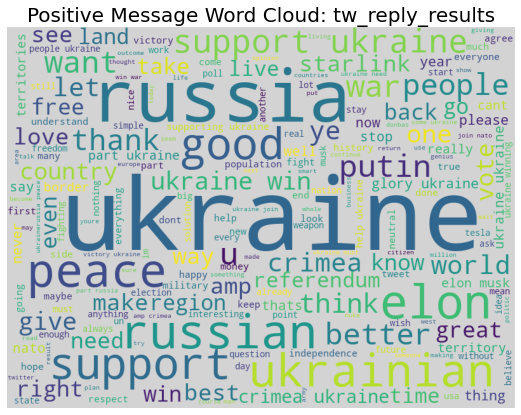

In [61]:
show_wordcloud(df_tw_reply_predictions_positive, "Positive Message Word Cloud: tw_reply_results")

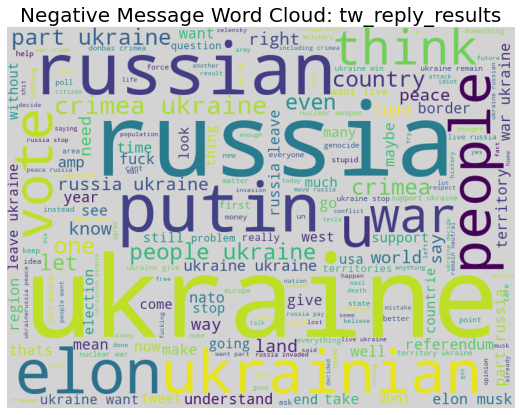

In [62]:
show_wordcloud(df_tw_reply_predictions_negative, "Negative Message Word Cloud: tw_reply_results")

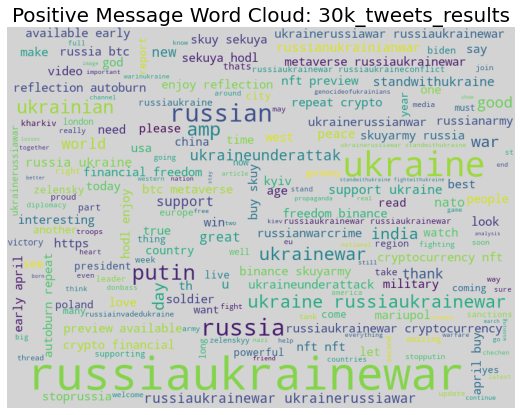

In [63]:
show_wordcloud(df_30K_Tweets_predictions_positive, "Positive Message Word Cloud: 30k_tweets_results")

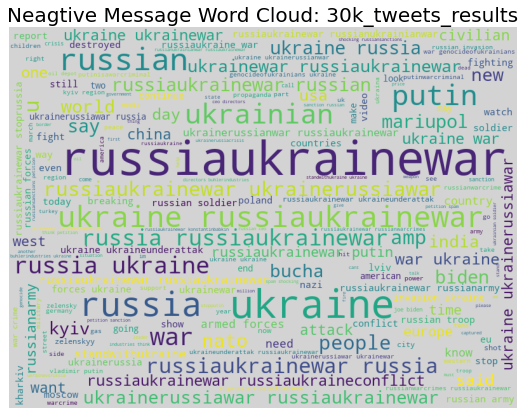

In [64]:
show_wordcloud(df_30K_Tweets_predictions_negative, "Neagtive Message Word Cloud: 30k_tweets_results")

In [65]:
df_tw_postive_word = Counter(" ".join(df_tw_reply_predictions_positive["message"]).split()).most_common(100)
df_tw_reply_positive_word_distribution = pd.DataFrame(df_tw_postive_word)
df_tw_reply_positive_word_distribution.columns = ['Word', 'Count']
df_tw_reply_positive_word_distribution.head(20)


Word  Count
0   ukraine   6535
1    russia   2003
2   support    943
3      elon    807
4     peace    778
5    crimea    690
6      good    577
7       war    539
8    people    535
9       win    489
10  russian    488
11    would    452
12   better    413
13     like    407
14    great    391
15     want    385
16    world    355
17    putin    353
18     part    345
19       us    343

In [66]:
#Word frequency for negative classes tw_reply_results
df_tw_reply_predictions_negative['message'] = df_tw_reply_predictions_negative['message'].astype(str)
df_tw_negative_word = Counter(" ".join(df_tw_reply_predictions_negative["message"]).split()).most_common(100)
df_tw_reply_negative_word_distribution = pd.DataFrame(df_tw_negative_word)
df_tw_reply_negative_word_distribution .columns = ['Word', 'Count']
df_tw_reply_negative_word_distribution.head(15)


<ipython-input-66-ff2cb5c8874c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tw_reply_predictions_negative['message'] = df_tw_reply_predictions_negative['message'].astype(str)


Word  Count
0   ukraine  51710
1    russia  24116
2    people  10167
3    crimea   8336
4       war   7967
5   russian   6290
6     putin   5386
7      want   4941
8      elon   4886
9     peace   4116
10     part   4107
11    would   3737
12     stop   3526
13  country   3259
14     like   3092

In [67]:
#Word frequency for positive classes 30k_tweets_results
df_30k_postive_word = Counter(" ".join(df_30K_Tweets_predictions_positive["message"]).split()).most_common(100)
df_30k_tweet_positive_word_distribution = pd.DataFrame(df_30k_postive_word)
df_30k_tweet_positive_word_distribution.columns = ['Word', 'Count']
df_30k_tweet_positive_word_distribution.head(15)

Word  Count
0   russiaukrainewar    777
1            ukraine    423
2             russia    188
3            russian    105
4   ukrainerussiawar     86
5            support     76
6              putin     75
7                amp     75
8                nft     73
9         ukrainewar     64
10               war     62
11  standwithukraine     54
12         ukrainian     51
13             india     51
14              good     50

In [68]:
#Word frequency for negative classes tw_reply_results
df_30K_Tweets_predictions_negative['message'] = df_30K_Tweets_predictions_negative['message'].astype(str)
df_30k_negative_word = Counter(" ".join(df_30K_Tweets_predictions_negative["message"]).split()).most_common(100)
df_30K_Tweets_negative_word_distribution = pd.DataFrame(df_30k_negative_word)
df_30K_Tweets_negative_word_distribution .columns = ['Word', 'Count']
print(df_30K_Tweets_negative_word_distribution.head())


               Word  Count
0  russiaukrainewar   5751
1           ukraine   3746
2            russia   2191
3           russian   1691
4               war   1125


<ipython-input-68-fa3d59f68782>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30K_Tweets_predictions_negative['message'] = df_30K_Tweets_predictions_negative['message'].astype(str)


In [69]:
df_tw_reply_positive_word_distribution.to_csv('df_tw_reply_positive_word_distribution.csv')
df_tw_reply_negative_word_distribution.to_csv('df_tw_reply_negative_word_distribution.csv')
df_30k_tweet_positive_word_distribution.to_csv('df_30k_tweet_positive_word_distribution.csv')
df_30K_Tweets_negative_word_distribution.to_csv('df_30K_Tweets_negative_word_distribution.csv')

## Keyword extraction using YAKE Dataset 1

In [70]:
df_30K_reply_predictions_yake = pd.read_csv('Predictions - 30K Tweets with russiaukrainewar hashtag.csv')
df_30K_reply_predictions_yake_crop = df_30K_reply_predictions_yake.copy()

In [71]:
df_30K_reply_predictions_yake_crop.dropna(subset = ['Cleaned'],inplace=True)
try:
  df_30K_reply_predictions_yake_crop.reset_index(inplace=True)
except:
  pass
df_30K_reply_predictions_yake_crop['Cleaned'].str.lower()

remove_index = []
print(f"The was originally {len(df_30K_reply_predictions_yake_crop )} tweets")


for i in range(len(df_30K_reply_predictions_yake_crop )):
  if "ukraine" not in df_30K_reply_predictions_yake_crop .loc[i,'Cleaned']:
    remove_index.append(i)


df_30K_reply_predictions_yake_crop_ukraine = df_30K_reply_predictions_yake_crop.copy()
df_30K_reply_predictions_yake_crop_ukraine.drop(remove_index,axis=0,inplace=True)
df_30K_reply_predictions_yake_crop_ukraine = df_30K_reply_predictions_yake_crop_ukraine.reset_index(drop=True)
print(f"There is {len(df_30K_reply_predictions_yake_crop_ukraine)} that contains the word ukraine")

The was originally 9153 tweets
There is 7459 that contains the word ukraine


In [72]:
df_30K_reply_predictions_yake_crop_ukraine.head()

index  Unnamed: 0              Author_name  #Followers  \
0     11          15  himanshu7saIndiadiadiai          18   
1     14          18             alyonational        6593   
2     16          22                  KatzbyJ         239   
3     20          30                anny_more        2370   
4     21          32          orange_capybara         112   

   Author FollowIndiadiadiag            Account Created  Verified  \
0                        194  2016-01-08 13:13:53+00:00     False   
1                        541  2010-01-29 19:54:29+00:00     False   
2                        198  2021-01-23 11:33:11+00:00     False   
3                        246  2010-01-30 22:20:11+00:00     False   
4                         88  2016-08-05 17:39:26+00:00     False   

                 Location                                              Tweet  \
0  Jaipur, Indiadiadiadia  RT @OTregub: A deer with deep burns rescued by...   
1                    Киев  Hello world. My name is Alyona, i'm Ukrainian....   
2                     NYC  The #Bucha Massacre : Young boy murdered by Ru...   
3                      K.  Hello world. My name is Ann, i'm Ukrainian. \n...   
4     Луганщина ➡️ Харків  Hello world. It's me. My name is  Zlata, i'm U...   

     Length  Likes Language  Retweets                       Time  \
0  [0, 140]      0       en      2266  2022-04-03 15:25:00+00:00   
1  [0, 278]     21       en         2  2022-04-03 15:24:09+00:00   
2  [0, 138]      0       en         0  2022-04-03 15:23:24+00:00   
3  [0, 275]     11       en         3  2022-04-03 15:21:34+00:00   
4  [0, 266]      6       en         1  2022-04-03 15:21:15+00:00   

                                             Cleaned  label_predict  
0   deer deep burns rescued local residents russi...              0  
1  hello world name alyona im ukrainian photo lef...              0  
2  bucha massacre  young boy murdered russian arm...              0  
3  hello world name ann im ukrainian photo left a...              0  
4  hello world me name zlata im ukrainian photo l...              0

In [73]:
def yake_keyword(df,feature):

  df['Yake Keywords'] = ""
  key_word_list = []
  kw_extractor = yake.KeywordExtractor()
  for i in range(len(df)):
    if i % 1000 == 0:
      print(i)

    
    
    text = df[feature].loc[i]
    keywords = kw_extractor.extract_keywords(text)
    key_word_list = []
    for kw in keywords:
      if (kw[1] > 0.1):
        key_word_list.append(kw[0])
      
      # Make sure there's no duplicates
      key_word_list_modified = list(set(key_word_list))
      key_words_string = ",".join(key_word_list_modified) # Join one string instead of list
      df.loc[i,'Yake Keywords'] = key_words_string

  return df




In [74]:
df_30K_reply_predictions_yake_crop = yake_keyword(df_30K_reply_predictions_yake_crop_ukraine,'Cleaned')


0
1000
2000
3000
4000
5000
6000
7000


In [75]:
df_30K_reply_predictions_yake_crop.to_csv('df_30K_reply_predictions_yake_crop.csv') 
files.download('df_30K_reply_predictions_yake_crop.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
# Create two tables one for positive sentiment and negative sentiment
df_30K_neg = df_30K_reply_predictions_yake_crop[df_30K_reply_predictions_yake_crop['label_predict']==0] # Negative Table
df_30K_pos = df_30K_reply_predictions_yake_crop[df_30K_reply_predictions_yake_crop['label_predict']==1] # Positive Table

# Get all words in yake extracted important words
neg_important_words = " ".join(important_word for important_word in df_30K_neg["Yake Keywords"].astype(str))
pos_important_words = " ".join(important_word for important_word in df_30K_pos["Yake Keywords"].astype(str))

In [77]:
# Function for cloud map
def cloud_map(text,title):
    
    wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

    # Display the generated image:
    # the matplotlib way:

    plt.figure( figsize=(30,20))
    #plt.tight_layout(pad=0)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize = 75)
    plt.show()

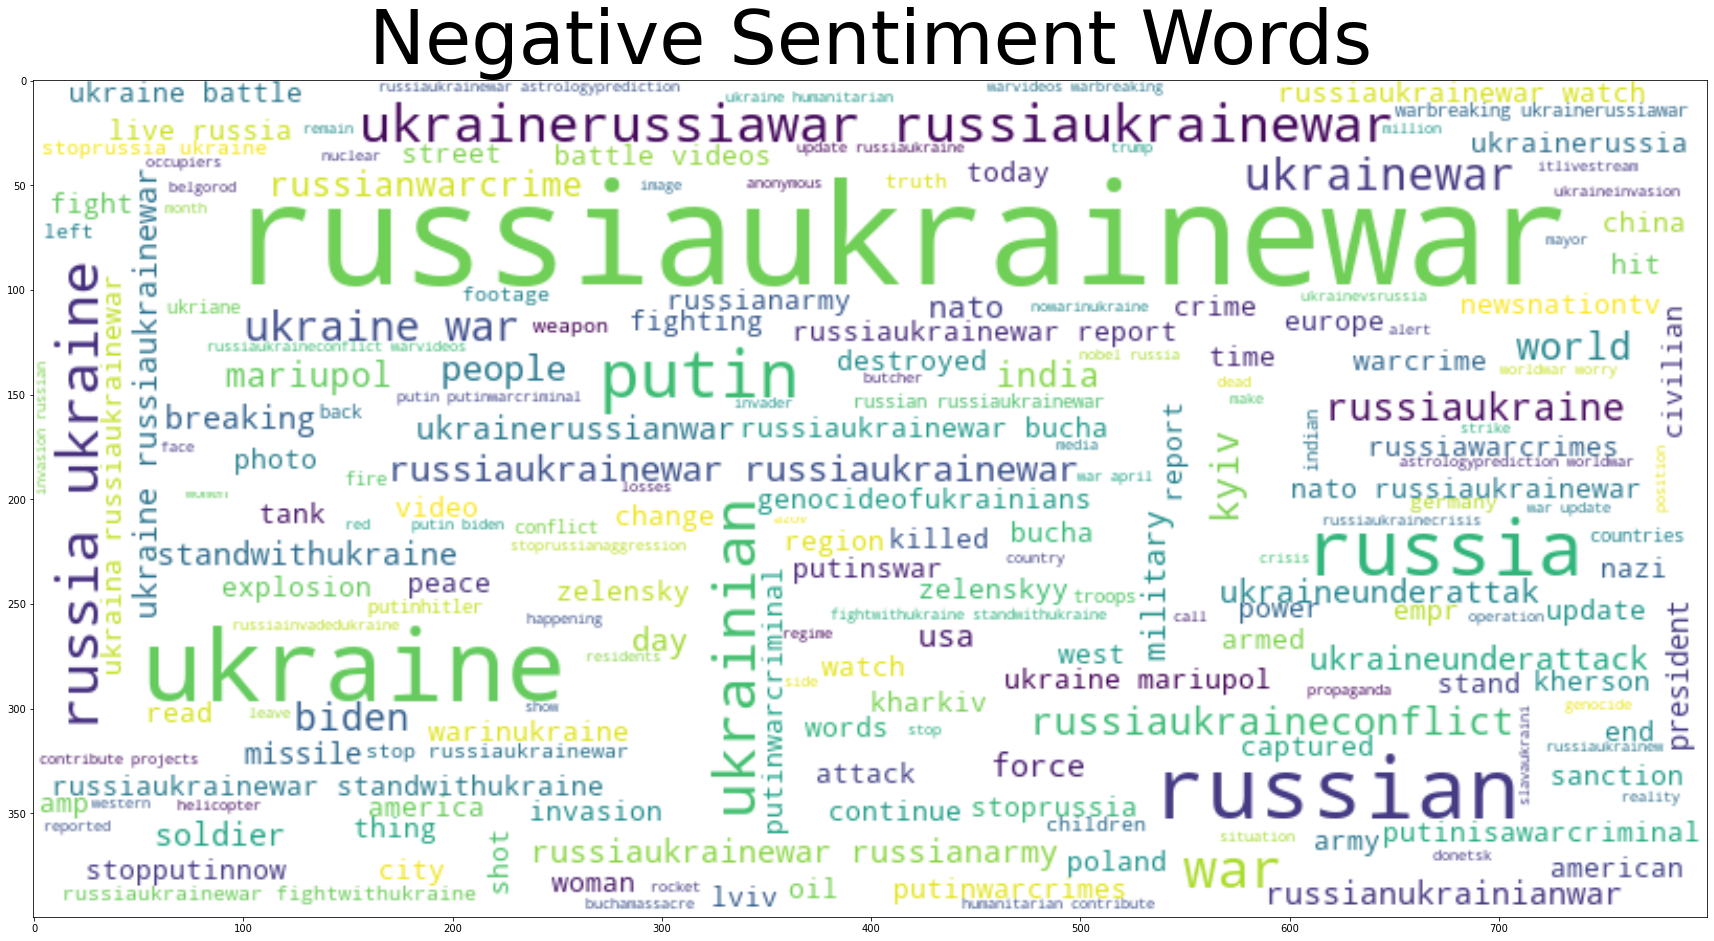

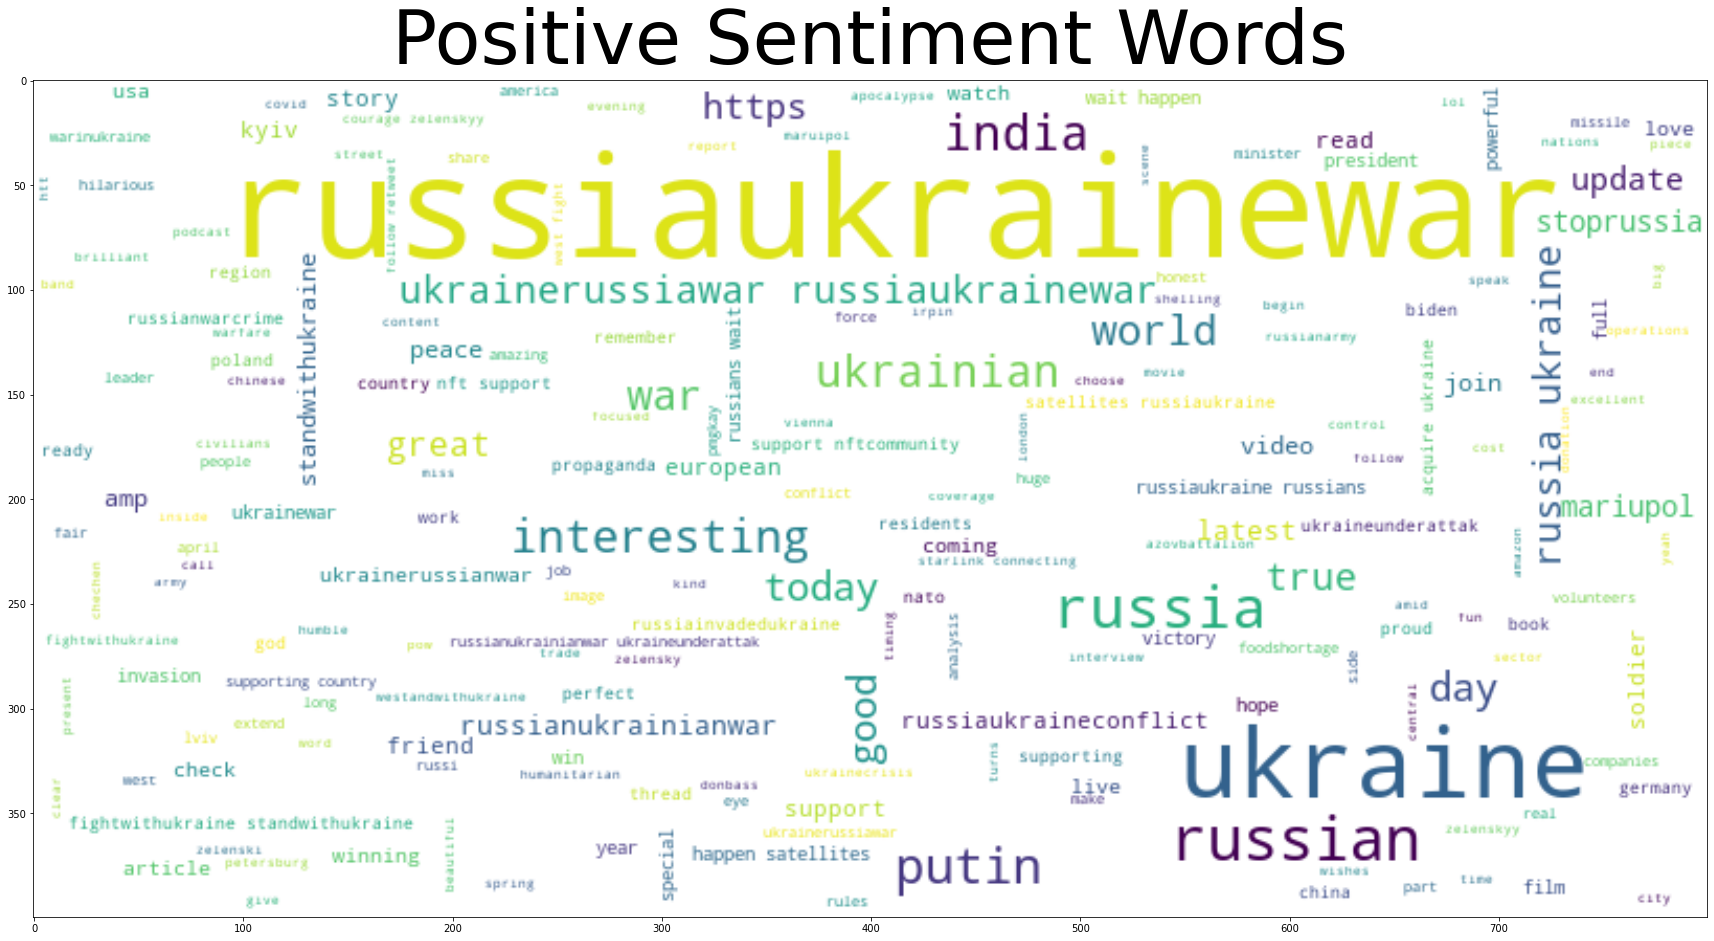

In [78]:
cloud_map(neg_important_words, "Negative Sentiment Words")
cloud_map(pos_important_words, "Positive Sentiment Words")

## Keyword extraction using YAKE Dataset 2

In [79]:
df_tw_yake = pd.read_csv('Prediction - tw_reply.csv')
df_tw_yake_crop = df_tw_yake.copy()
df_tw_yake_crop = df_tw_yake_crop.loc[:100000,:]
df_tw_yake_crop.dropna(subset = ['Cleaned'],inplace=True)
df_tw_yake_crop.reset_index(inplace=True)

In [80]:
df_tw_yake_crop.dropna(subset = ['Cleaned'],inplace=True)
try:
  df_tw_yake_crop.reset_index(inplace=True)
except:
  pass
df_tw_yake_crop['Cleaned'].str.lower()

remove_index = []
print(f"The was originally {len(df_tw_yake_crop)} tweets")


for i in range(len(df_tw_yake_crop)):
  if "ukraine" not in df_tw_yake_crop.loc[i,'Cleaned']:
    remove_index.append(i)


df_30K_reply_predictions_yake_crop_ukraine = df_tw_yake_crop.copy()
df_30K_reply_predictions_yake_crop_ukraine.drop(remove_index,axis=0,inplace=True)
df_30K_reply_predictions_yake_crop_ukraine = df_30K_reply_predictions_yake_crop_ukraine.reset_index(drop=True)
print(f"There is {len(df_30K_reply_predictions_yake_crop_ukraine)} that contains the word ukraine")

The was originally 94843 tweets
There is 13457 that contains the word ukraine


In [81]:
df_tw_yake_crop = yake_keyword(df_30K_reply_predictions_yake_crop_ukraine,'Cleaned')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [82]:
df_tw_yake_crop.dropna(subset = ['Yake Keywords'],inplace=True)
df_tw_yake_crop.head()

level_0  index  Unnamed: 0                created_at  \
0       14     14          14  2022-10-06T23:29:08.000Z   
1       23     23          23  2022-10-06T23:20:41.000Z   
2       33     33          33  2022-10-06T23:08:38.000Z   
3       35     35          35  2022-10-06T23:06:50.000Z   
4       38     39          39  2022-10-06T23:04:09.000Z   

                                                text  in_reply_to_tweet_id  \
0  @elonmusk Maybe - only if each Ukrainian who w...   1576994262226702336   
1  @elonmusk Im quite disappointed with your idea...   1576994262226702336   
2  @elonmusk Ukraine is a sovereign country. What...   1576994262226702336   
3  @elonmusk American opinions (your tweet) are i...   1576994262226702336   
4  @elonmusk They already did. That’s why they ar...   1576994262226702336   

   retweet_count  reply_count  like_count  \
0              0            0           0   
1              0            2           3   
2              0            0           0   
3              0            0           1   
4              0            0           2   

                                             Cleaned  label_predict  \
0   maybe  ukrainian killed special military oper...              0   
1   im quite disappointed ideabecause voting unfa...              0   
2            ukraine sovereign country nonsense poll              0   
3   american opinions your tweet irrelevant sover...              0   
4                    already did thats part ukraine               0   

                             Yake Keywords  
0                                           
1                                           
2  poll,nonsense,ukraine,sovereign,country  
3                                           
4                             ukraine,part

In [83]:
df_tw_yake_crop.to_csv('df_tw_yake_crop.csv') 
files.download('df_tw_yake_crop.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
df_tw_yake_crop = pd.read_csv('df_tw_yake_crop.csv')

In [85]:
df_tw_yake_crop.head()

Unnamed: 0  level_0  index  Unnamed: 0.1                created_at  \
0           0       14     14            14  2022-10-06T23:29:08.000Z   
1           1       23     23            23  2022-10-06T23:20:41.000Z   
2           2       33     33            33  2022-10-06T23:08:38.000Z   
3           3       35     35            35  2022-10-06T23:06:50.000Z   
4           4       38     39            39  2022-10-06T23:04:09.000Z   

                                                text  in_reply_to_tweet_id  \
0  @elonmusk Maybe - only if each Ukrainian who w...   1576994262226702336   
1  @elonmusk Im quite disappointed with your idea...   1576994262226702336   
2  @elonmusk Ukraine is a sovereign country. What...   1576994262226702336   
3  @elonmusk American opinions (your tweet) are i...   1576994262226702336   
4  @elonmusk They already did. That’s why they ar...   1576994262226702336   

   retweet_count  reply_count  like_count  \
0              0            0           0   
1              0            2           3   
2              0            0           0   
3              0            0           1   
4              0            0           2   

                                             Cleaned  label_predict  \
0   maybe  ukrainian killed special military oper...              0   
1   im quite disappointed ideabecause voting unfa...              0   
2            ukraine sovereign country nonsense poll              0   
3   american opinions your tweet irrelevant sover...              0   
4                    already did thats part ukraine               0   

                             Yake Keywords  
0                                      NaN  
1                                      NaN  
2  poll,nonsense,ukraine,sovereign,country  
3                                      NaN  
4                             ukraine,part

In [86]:
# Create two tables one for positive sentiment and negative sentiment
df_tw_neg= df_tw_yake_crop[df_tw_yake_crop['label_predict']==0] # Negative Table
df_tw_pos = df_tw_yake_crop[df_tw_yake_crop['label_predict']==1] # Positive Table

# Get all words in yake extracted important words
neg_important_words = " ".join(important_word for important_word in df_tw_neg["Yake Keywords"].astype(str))
pos_important_words = " ".join(important_word for important_word in df_tw_pos["Yake Keywords"].astype(str))

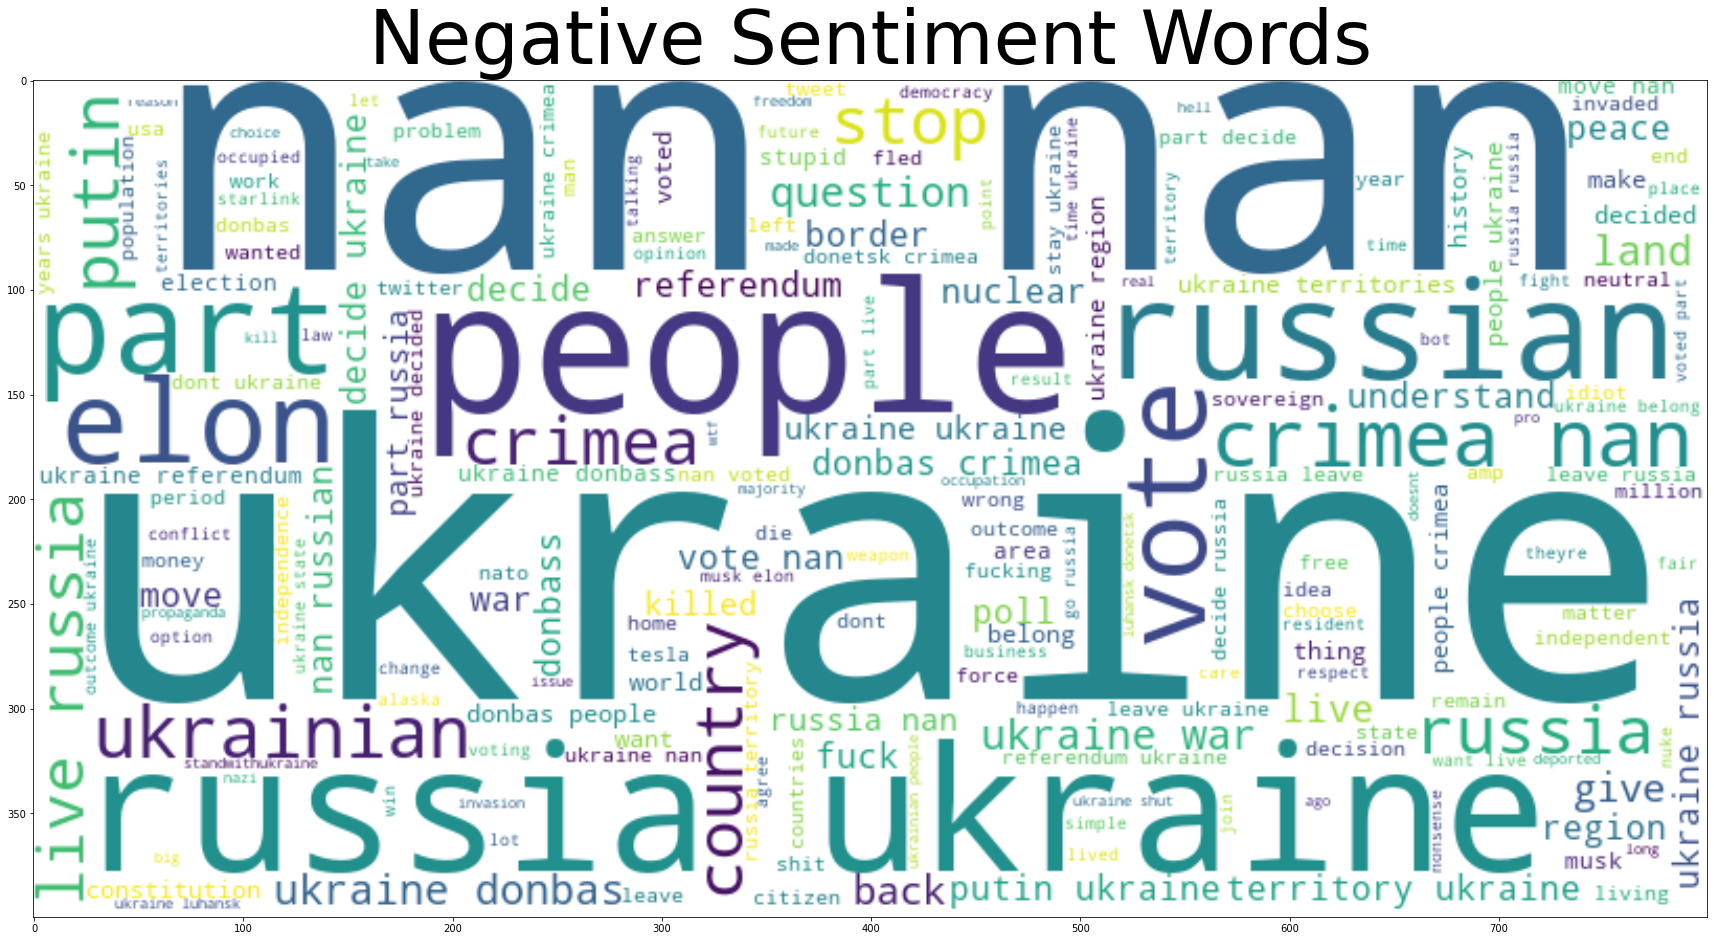

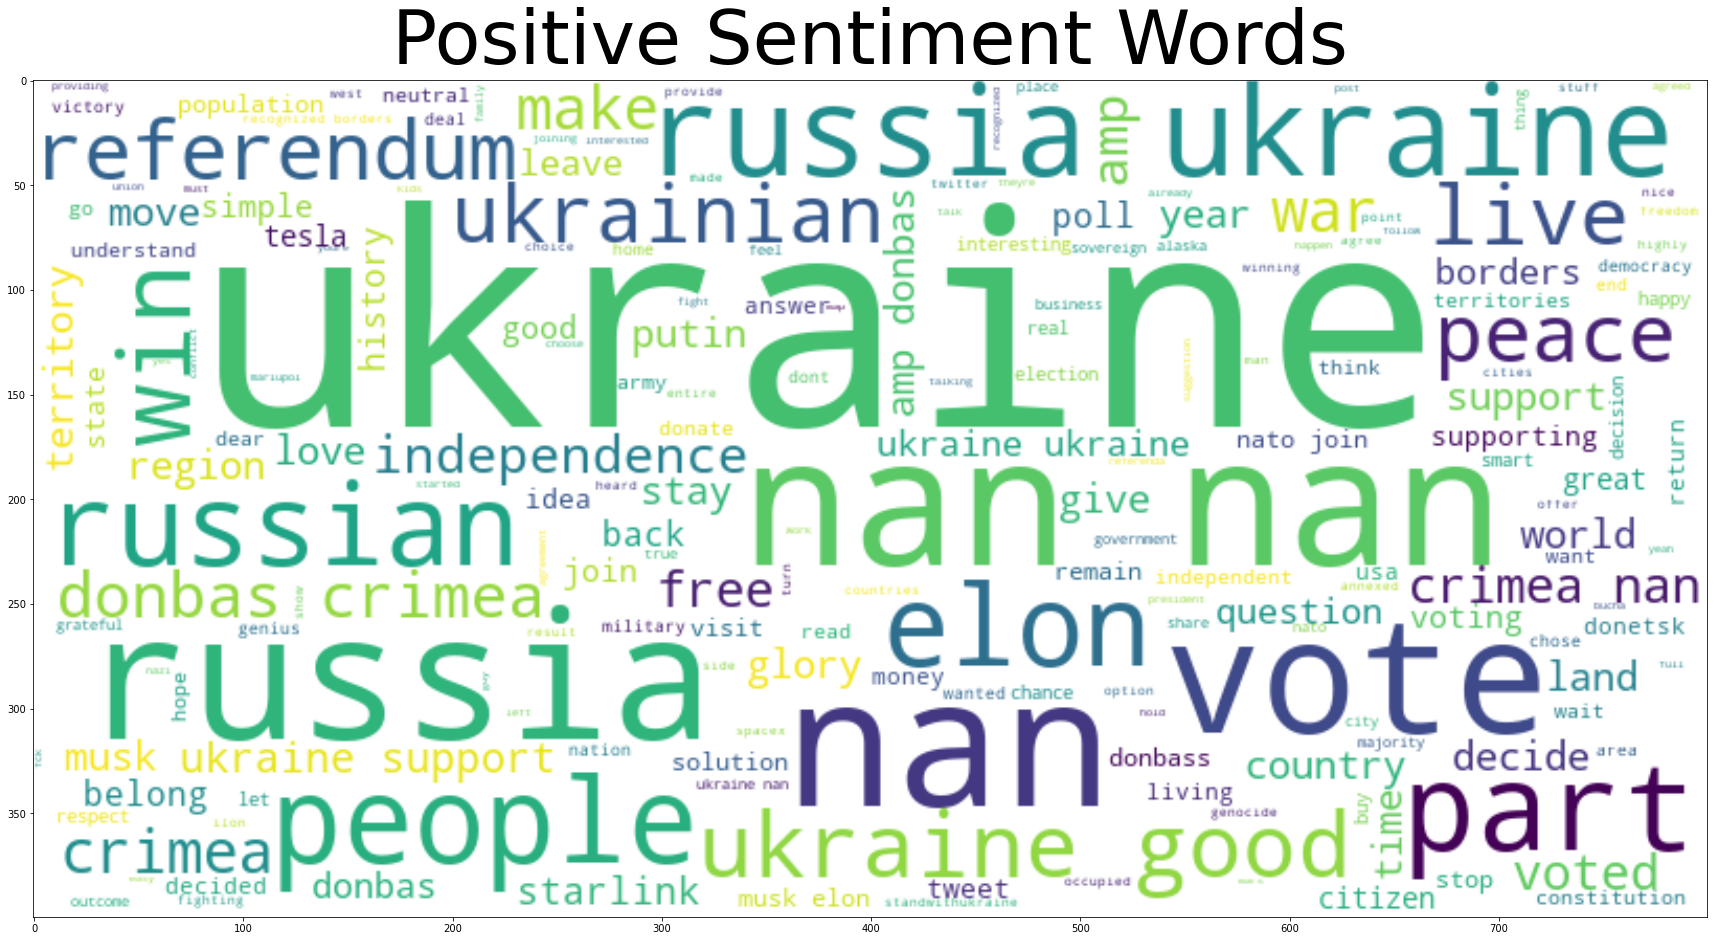

In [87]:
cloud_map(neg_important_words, "Negative Sentiment Words")
cloud_map(pos_important_words, "Positive Sentiment Words")

We will choose a list of words that seems interesting and calculate the relative percentage of time they appear in their sentiment.

In [88]:
## Remove later
df_tw_yake_crop = pd.read_csv('df_tw_yake_crop.csv')

In [89]:
df_tw_yake_crop.head()

Unnamed: 0  level_0  index  Unnamed: 0.1                created_at  \
0           0       14     14            14  2022-10-06T23:29:08.000Z   
1           1       23     23            23  2022-10-06T23:20:41.000Z   
2           2       33     33            33  2022-10-06T23:08:38.000Z   
3           3       35     35            35  2022-10-06T23:06:50.000Z   
4           4       38     39            39  2022-10-06T23:04:09.000Z   

                                                text  in_reply_to_tweet_id  \
0  @elonmusk Maybe - only if each Ukrainian who w...   1576994262226702336   
1  @elonmusk Im quite disappointed with your idea...   1576994262226702336   
2  @elonmusk Ukraine is a sovereign country. What...   1576994262226702336   
3  @elonmusk American opinions (your tweet) are i...   1576994262226702336   
4  @elonmusk They already did. That’s why they ar...   1576994262226702336   

   retweet_count  reply_count  like_count  \
0              0            0           0   
1              0            2           3   
2              0            0           0   
3              0            0           1   
4              0            0           2   

                                             Cleaned  label_predict  \
0   maybe  ukrainian killed special military oper...              0   
1   im quite disappointed ideabecause voting unfa...              0   
2            ukraine sovereign country nonsense poll              0   
3   american opinions your tweet irrelevant sover...              0   
4                    already did thats part ukraine               0   

                             Yake Keywords  
0                                      NaN  
1                                      NaN  
2  poll,nonsense,ukraine,sovereign,country  
3                                      NaN  
4                             ukraine,part

### Code for Power BI 1

In [108]:
df_tw_yake_crop.dropna(subset = ['Yake Keywords'],inplace=True)

In [109]:
df_tw_yake_crop = df_tw_yake_crop.reset_index(drop=True)

In [110]:
df_tw_yake_crop.head()

Unnamed: 0  level_0  index  Unnamed: 0.1                created_at  \
0           2       33     33            33  2022-10-06T23:08:38.000Z   
1           4       38     39            39  2022-10-06T23:04:09.000Z   
2           8       56     59            59  2022-10-06T22:28:12.000Z   
3           9       59     62            62  2022-10-06T22:26:18.000Z   
4          10       67     70            70  2022-10-06T22:19:34.000Z   

                                                text  in_reply_to_tweet_id  \
0  @elonmusk Ukraine is a sovereign country. What...   1576994262226702336   
1  @elonmusk They already did. That’s why they ar...   1576994262226702336   
2  @elonmusk No.  Stfu about Ukraine, focus on sp...   1576994262226702336   
3  @elonmusk If you don't live in Ukraine it's no...   1576994262226702336   
4  @elonmusk This you now shitcoiner 😎👍\n#Bitcoin...   1576994262226702336   

   retweet_count  reply_count  like_count  \
0              0            0           0   
1              0            0           2   
2              0            0           0   
3              0            0           0   
4              0            1           1   

                                             Cleaned  label_predict  \
0            ukraine sovereign country nonsense poll              0   
1                    already did thats part ukraine               0   
2             no stfu ukraine focus space janky cars              0   
3                              live ukraine business              0   
4   shitcoiner  bitcoin russia natorussiawar russ...              0   

                                       Yake Keywords  
0            poll,nonsense,ukraine,sovereign,country  
1                                       ukraine,part  
2                ukraine,cars,space,janky,stfu,focus  
3                              ukraine,business,live  
4  russia,natorussiawar,bitcoin,shitcoiner,russia...

In [111]:
# List of word 
Word_List = ['donbas','crimea','referendum','independence','money','border','starlink','peace','putin','elon']
Word_List_Pos = []
Word_List_Neg = []

count_total_neg = len(df_tw_yake_crop['label_predict'] == 0)
count_total_pos = len(df_tw_yake_crop['label_predict'] == 1)
count_word_pos = 0
count_word_neg = 0 

for word in Word_List:
  count_word_pos = 0 
  count_word_neg = 0
  for j in range(len(df_tw_yake_crop)):
    # Count number of times each words appear in Yake Keywords
    if word in df_tw_yake_crop['Yake Keywords'].loc[j] and df_tw_yake_crop['label_predict'].loc[j] == 1:
      count_word_pos += 1

    if word in df_tw_yake_crop['Yake Keywords'].loc[j] and df_tw_yake_crop['label_predict'].loc[j] == 0:
      count_word_neg += 1

  Word_List_Pos.append(count_word_pos)
  Word_List_Neg.append(count_word_neg)

relative_tot_pos = []
relative_tot_neg = []


for x in Word_List_Neg:
    relative_tot_neg.append(x/count_total_neg) 

for x in Word_List_Pos:
    relative_tot_pos.append(x/count_total_pos) 

print(relative_tot_pos)
print(Word_List_Pos)
print(Word_List_Neg)

[0.00973296730721238, 0.012228599950087347, 0.004616920389318692, 0.0036186673321687048, 0.001123034689293736, 0.0023708510107312204, 0.0021212877464437236, 0.0049912652857499375, 0.0024956326428749688, 0.010606438732218617]
[78, 98, 37, 29, 9, 19, 17, 40, 20, 85]
[691, 864, 272, 59, 52, 117, 39, 111, 344, 595]


In [112]:
d_words = {'Words': Word_List, 'Word Count Positive':Word_List_Pos,'Relative Ratio Positive':relative_tot_pos,'Word Count Negative':Word_List_Neg, 'Relative Ratio Negative':relative_tot_neg}
df_word_analysis = pd.DataFrame(d_words)
df_word_analysis.head(10)

Words  Word Count Positive  Relative Ratio Positive  \
0        donbas                   78                 0.009733   
1        crimea                   98                 0.012229   
2    referendum                   37                 0.004617   
3  independence                   29                 0.003619   
4         money                    9                 0.001123   
5        border                   19                 0.002371   
6      starlink                   17                 0.002121   
7         peace                   40                 0.004991   
8         putin                   20                 0.002496   
9          elon                   85                 0.010606   

   Word Count Negative  Relative Ratio Negative  
0                  691                 0.086224  
1                  864                 0.107811  
2                  272                 0.033941  
3                   59                 0.007362  
4                   52                 0.006489  
5                  117                 0.014599  
6                   39                 0.004866  
7                  111                 0.013851  
8                  344                 0.042925  
9                  595                 0.074245

In [113]:
df_word_analysis.to_csv('df_word_analysis.csv') 
files.download('df_word_analysis.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>